# Inerpretation-Net Training

# Experiment 1: I-Net Performance for Different Algebras and Complexities
# Experiment 2: I-Net Performance Comparison for λ-Nets with Different Training Levels
# Experiment 3: I-Net Performance Comparison Different Training Data Sizes

## Specitication of Experiment Settings

In [1]:
#######################################################################################################################################
###################################################### CONFIG FILE ####################################################################
#######################################################################################################################################
sleep_time = 20 #minutes


config = {
    'data': {
        'd': 5, #degree
        'n': 1, #number of variables
        'sparsity': None,
        'sample_sparsity': 3,
        'x_max': 1,
        'x_min': 0,
        'x_distrib': 'uniform', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        'a_max': 1,
        'a_min': -1,
        'lambda_nets_total': 10000,
        'noise': 0.25,
        'noise_distrib': 'normal', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        
        'same_training_all_lambda_nets': False,

        'fixed_seed_lambda_training': True,
        'fixed_initialization_lambda_training': False,
        'number_different_lambda_trainings': 1,
        
    },
    'lambda_net': {
        'epochs_lambda': 200,
        'batch_lambda': 64,
        'dropout': 0,
        'lambda_network_layers': [5*'sparsity'],
        'optimizer_lambda': 'adam',
        'number_of_lambda_weights': None,
        'lambda_dataset_size': 1000,
    },
    'i_net': {
        'optimizer': 'custom',#adam
        'dropout': 0.25,
        'epochs': 100,
        'early_stopping': True,
        'batch_size': 512,
        'dense_layers': [512, 1024],
        'convolution_layers': None,
        'lstm_layers': None,
        'interpretation_dataset_size': 10000,
                
        'interpretation_net_output_monomials': None, #(None, int)
        'interpretation_net_output_shape': None, #calculated automatically later
        
        'evaluate_with_real_function': False,
        'consider_labels_training': False,
        
        'seed_in_inet_training': False,
              
        'data_reshape_version': None, #default to 2 options:(None, 0,1 2)
        'nas': False,
        'nas_type': None, #options:(None, 'CNN', 'LSTM', 'CNN-LSTM', 'CNN-LSTM-parallel')      
        'nas_trials': 0,
    },
    'evaluation': {   
        'inet_holdout_seed_evaluation': False,
        
        #set if multi_epoch_analysis should be performed
        'multi_epoch_analysis': True,
        'each_epochs_save_lambda': 20,
        'epoch_start': 0, #use to skip first epochs in multi_epoch_analysis
        
        #set if samples analysis should be performed
        'samples_list': None,#[100, 500, 750, 1000, 2500, 5000, 7500, 10000, 15000, 20000, 25000, 28125] 
       
        'random_evaluation_dataset_size': 500,
    },
    'computation':{
        'n_jobs': 11,
        'use_gpu': False,
        'gpu_numbers': '0',
        'RANDOM_SEED': 42,   
    }
}

## Imports

In [2]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [3]:
#######################################################################################################################################
##################################################### IMPORT LIBRARIES ################################################################
#######################################################################################################################################
from utilities.InterpretationNet import *
from utilities.LambdaNet import *
from utilities.metrics import *
from utilities.utility_functions import *


from itertools import product       
from tqdm import tqdm_notebook as tqdm
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import timeit
import psutil

from functools import reduce
from more_itertools import random_product 
from sklearn.preprocessing import Normalizer


import os
import shutil

import logging

from prettytable import PrettyTable
import colored
import math

import time
from datetime import datetime
from collections.abc import Iterable


from joblib import Parallel, delayed

from scipy.integrate import quad

from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score
from similaritymeasures import frechet_dist, area_between_two_curves, dtw
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.utils import plot_model
from IPython.display import Image

import keras.backend as K
from livelossplot import PlotLossesKerasTF
from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from matplotlib import pyplot as plt
import seaborn as sns


import tensorflow as tf
import random 


import warnings


from IPython.display import display, Math, Latex



In [4]:
#######################################################################################################################################
################################################### VARIABLE ADJUSTMENTS ##############################################################
#######################################################################################################################################
variables = 'abcdefghijklmnopqrstuvwxyz'[:n]

n_jobs = min((epochs_lambda//each_epochs_save_lambda+1, n_jobs)) if multi_epoch_analysis else min(len(samples_list), n_jobs) if samples_list!=None else 1

each_epochs_save_lambda = each_epochs_save_lambda if multi_epoch_analysis else epochs_lambda
epochs_save_range_lambda = range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda) if each_epochs_save_lambda == 1 else range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda+1) if multi_epoch_analysis else range(1,2)

#######################################################################################################################################
###################################################### SET VARIABLES + DESIGN #########################################################
#######################################################################################################################################

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers if use_gpu else ''

logging.getLogger('tensorflow').disabled = True

sns.set_style("darkgrid")
#np.set_printoptions(suppress=True)

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 500)

warnings.filterwarnings('ignore')

In [5]:
#######################################################################################################################################
####################################################### CONFIG ADJUSTMENTS ############################################################
#######################################################################################################################################
config['evaluation']['each_epochs_save_lambda'] = each_epochs_save_lambda

config['data']['sparsity'] = nCr(config['data']['n']+config['data']['d'], config['data']['d'])
config['data']['sample_sparsity'] = config['data']['sparsity'] if config['data']['sample_sparsity'] == None else config['data']['sample_sparsity']

config['i_net']['interpretation_net_output_shape'] = config['data']['sparsity'] if config['i_net']['interpretation_net_output_monomials'] is None else 2*config['i_net']['interpretation_net_output_monomials']


transformed_layers = []
for layer in config['lambda_net']['lambda_network_layers']:
    if type(layer) == str:
        transformed_layers.append(layer.count('sparsity')*config['data']['sparsity'])
    else:
        transformed_layers.append(layer)
config['lambda_net']['lambda_network_layers'] = transformed_layers

layers_with_input_output = list(flatten([[config['data']['n']], config['lambda_net']['lambda_network_layers'], [1]]))
number_of_lambda_weights = 0
for i in range(len(layers_with_input_output)-1):
    number_of_lambda_weights += (layers_with_input_output[i]+1)*layers_with_input_output[i+1]  
config['lambda_net']['number_of_lambda_weights'] = number_of_lambda_weights
    
#######################################################################################################################################
################################################## UPDATE VARIABLES ###################################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])



initialize_LambdaNet_config_from_curent_notebook(config)
initialize_metrics_config_from_curent_notebook(config)
initialize_utility_functions_config_from_curent_notebook(config)
initialize_InterpretationNet_config_from_curent_notebook(config)


#######################################################################################################################################
###################################################### PATH + FOLDER CREATION #########################################################
#######################################################################################################################################
globals().update(generate_paths(path_type='interpretation_net'))
create_folders_inet()

#######################################################################################################################################
############################################################ SLEEP TIMER ##############################################################
#######################################################################################################################################
sleep_minutes(sleep_time)

In [6]:
print(path_identifier_interpretation_net_data)

print(path_identifier_lambda_net_data)


inet_dense[512, 1024]convNonelstmNoneoutput_6_drop0.25e100b512_customlnets_10000_30-200e64b_adam_train_1000_var_1_d_5_sparsity_3_amin_-1_amax_1_xmin_0_xmax_1_xdist_uniform_noise_normal_0.25_diffX_1-FixSeed_42
lnets_10000_30-200e64b_adam_train_1000_var_1_d_5_sparsity_3_amin_-1_amax_1_xmin_0_xmax_1_xdist_uniform_noise_normal_0.25_diffX_1-FixSeed_42


In [7]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  0
Num XLA-GPUs Available:  0


## Utility functions

### Generate List of Monomial Identifiers

In [8]:
list_of_monomial_identifiers_extended = []
for i in tqdm(range((d+1)**n)):    
    monomial_identifier = dec_to_base(i, base = (d+1)).zfill(n) 
    list_of_monomial_identifiers_extended.append(monomial_identifier)

print('List length: ' + str(len(list_of_monomial_identifiers_extended)))
print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(nCr(n+d, d)))
print('Sparsity: ' + str(sparsity))
print(list_of_monomial_identifiers_extended)

list_of_monomial_identifiers = []
for monomial_identifier in tqdm(list_of_monomial_identifiers_extended):
    monomial_identifier_values = list(map(int, list(monomial_identifier)))
    if sum(monomial_identifier_values) <= d:
        list_of_monomial_identifiers.append(monomial_identifier)

print('List length: ' + str(len(list_of_monomial_identifiers)))
print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(nCr(n+d, d)))
print('Sparsity: ' + str(sparsity))
print(list_of_monomial_identifiers)


layers_with_input_output = list(flatten([[n], lambda_network_layers, [1]]))
number_of_lambda_weights = 0
for i in range(len(layers_with_input_output)-1):
    number_of_lambda_weights += (layers_with_input_output[i]+1)*layers_with_input_output[i+1]

  0%|          | 0/6 [00:00<?, ?it/s]

List length: 6
Number of monomials in a polynomial with 1 variables and degree 5: 6
Sparsity: 6
['0', '1', '2', '3', '4', '5']


  0%|          | 0/6 [00:00<?, ?it/s]

List length: 6
Number of monomials in a polynomial with 1 variables and degree 5: 6
Sparsity: 6
['0', '1', '2', '3', '4', '5']


## Load Data and Generate Datasets

In [9]:
def load_lambda_nets(index):
    
    if psutil.virtual_memory().percent > 80:
        raise SystemExit("Out of RAM!")
    
    path = './data/weights/' + 'weights_' + path_identifier_lambda_net_data + '/weights_' + path_identifier_lambda_net_data + '_epoch_' + str(index).zfill(3) + '.txt'

    
    weight_data = pd.read_csv(path, sep=",", header=None)
    weight_data = weight_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    weight_data = weight_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)

    lambda_nets = []
    for _, row in weight_data.iterrows():
        lambda_net = LambdaNet(row.values)
        lambda_nets.append(lambda_net)
        
    lambda_net_dataset = LambdaNetDataset(lambda_nets)
        
    return lambda_net_dataset
    

In [10]:
#LOAD DATA

parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='multiprocessing')
lambda_net_dataset_list = parallel(delayed(load_lambda_nets)((i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1) for i in epochs_save_range_lambda)  
del parallel

lambda_net_dataset = lambda_net_dataset_list[-1]


[Parallel(n_jobs=11)]: Using backend MultiprocessingBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   2 out of  11 | elapsed:  5.6min remaining: 25.4min
[Parallel(n_jobs=11)]: Done   6 out of  11 | elapsed:  5.7min remaining:  4.8min
[Parallel(n_jobs=11)]: Done  11 out of  11 | elapsed:  5.8min finished


## Data Inspection

In [11]:
lambda_net_dataset.as_pandas().head()

,seed,0-target,1-target,2-target,3-target,4-target,5-target,0-lstsq_lambda,1-lstsq_lambda,2-lstsq_lambda,3-lstsq_lambda,4-lstsq_lambda,5-lstsq_lambda,0-lstsq_target,1-lstsq_target,2-lstsq_target,3-lstsq_target,4-lstsq_target,5-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90
6252,1373158606,0.924,0.492,0.000,0.000,-0.741,0.000,0.934,0.337,-0.613,6.030,-12.592,6.664,0.030,0.092,-1.053,2.260,-2.193,0.788,-0.009,-0.227,0.376,0.336,0.204,0.139,0.406,-0.297,0.331,0.112,0.486,-0.088,-0.019,0.415,0.128,0.461,-0.005,0.240,0.298,0.265,-0.007,0.041,0.008,-0.042,-0.404,-0.090,0.048,-0.291,-0.209,-0.233,0.000,0.000,-0.214,-0.192,0.231,0.230,-0.232,0.000,-0.193,0.292,-0.254,0.000,0.000,-0.236,0.240,-0.237,0.227,0.251,0.224,0.240,0.282,-0.047,-0.023,0.000,0.000,0.000,-0.052,0.000,0.000,0.000,-0.254,-0.359,-0.541,-0.662,0.348,0.402,-0.439,-0.408,-0.763,0.122,-0.343,-0.352,-0.364,-0.408,0.342,-0.423,0.670,0.223,0.361,0.254,0.321,-0.310,-0.044,-0.261,-0.383,-0.059,-0.335,0.144,-0.258,-0.315,0.198
4684,1373158606,0.000,0.241,0.000,-0.188,-0.535,0.000,-0.007,0.488,-3.798,13.197,-18.577,8.320,0.024,-0.049,-0.695,1.520,-1.493,0.541,-0.009,-0.227,0.311,0.270,0.217,0.155,0.307,-0.297,0.252,0.362,0.438,-0.088,-0.019,0.320,0.151,0.423,0.016,0.265,0.304,0.282,0.055,0.220,0.198,-0.042,-0.404,-0.090,0.227,-0.291,-0.209,-0.233,0.000,0.000,-0.184,-0.160,-0.000,0.000,-0.181,0.000,-0.149,-0.214,-0.034,0.000,0.000,-0.189,0.000,-0.033,0.001,-0.000,-0.000,-0.000,0.001,-0.130,-0.145,0.000,0.000,0.000,-0.134,0.000,0.000,0.000,-0.254,-0.359,-0.426,-0.559,0.199,0.227,-0.333,-0.408,-0.624,-0.199,-0.192,-0.352,-0.364,-0.294,0.160,-0.269,0.357,0.082,0.240,0.122,0.054,-0.734,-0.610,-0.261,-0.383,-0.059,-0.743,0.144,-0.258,-0.315,-0.004
1731,1373158606,-0.739,0.000,0.000,0.786,0.773,0.000,-0.742,-0.297,6.082,-23.077,33.725,-14.996,-0.035,-0.342,0.488,-0.989,0.933,-0.330,-0.009,-0.227,0.059,-0.066,0.544,0.464,-0.004,-0.297,-0.102,0.054,0.210,-0.088,-0.019,0.059,0.480,0.184,0.372,0.620,0.584,0.610,0.467,-0.159,-0.235,-0.042,-0.404,-0.090,-0.144,-0.291,-0.209,-0.233,0.000,0.000,0.156,0.165,-0.300,-0.334,0.165,0.000,0.168,0.168,0.145,0.000,0.000,0.157,-0.345,0.149,-0.268,-0.342,-0.314,-0.336,-0.336,0.172,0.244,0.000,0.000,0.000,0.170,0.000,0.000,0.000,-0.254,-0.359,-0.302,-0.414,0.760,0.860,-0.190,-0.408,-0.483,-0.032,-0.089,-0.352,-0.364,-0.160,0.810,-0.175,1.226,0.641,0.722,0.655,0.847,-0.595,-0.400,-0.261,-0.383,-0.059,-0.605,0.144,-0.258,-0.315,-0.154
4742,1373158606,0.173,-0.607,0.000,0.000,0.000,-0.939,0.118,0.876,-10.568,31.003,-38.900,16.342,-0.033,-0.361,0.410,-0.841,0.807,-0.290,-0.009,-0.227,0.447,0.395,0.112,0.045,0.391,-0.297,0.378,0.475,0.573,-0.088,-0.019,0.459,0.071,0.550,0.008,0.223,0.195,0.202,0.032,0.337,0.375,-0.042,-0.404,-0.090,0.351,-0.291,-0.209,-0.233,0.000,0.000,-0.020,-0.240,0.074,0.022,-0.238,0.000,-0.230,-0.289,-0.069,0.000,0.000,-0.045,-0.014,-0.066,-0.025,0.003,0.083,0.051,-0.043,-0.223,-0.248,0.000,0.000,0.000,-0.214,0.000,0.000,0.000,-0.254,-0.359,-0.454,-0.726,0.115,0.129,-0.397,-0.408,-0.796,-0.262,-0.313,-0.352,-0.364,-0.310,0.075,-0.390,0.393,-0.030,0.146,0.021,0.047,-0.917,-0.834,-0.261,-0.383,-0.059,-0.922,0.144,-0.258,-0.315,0.108
4521,1373158606,0.000,0.000,0.871,0.323,0.573,0.000,0.008,-0.402,4.281,-11.845,18.039,-8.469,0.030,0.088,-1.037,2.226,-2.161,0.777,-0.009,-0.227,0.123,0.083,0.554,0.460,0.197,-0.297,0.068,0.761,0.347,-0.088,-0.019,0.249,0.474,0.242,0.351,0.652,0.648,0.634,0.491,0.041,0.008,-0.042,-0.404,-0.090,0.047,-0.291,-0.209,-0.2

In [12]:
lambda_net_dataset.as_pandas().describe()

,seed,0-target,1-target,2-target,3-target,4-target,5-target,0-lstsq_lambda,1-lstsq_lambda,2-lstsq_lambda,3-lstsq_lambda,4-lstsq_lambda,5-lstsq_lambda,0-lstsq_target,1-lstsq_target,2-lstsq_target,3-lstsq_target,4-lstsq_target,5-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90
count,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000
mean,1373158606.000,-0.003,-0.001,0.004,0.007,-0.006,-0.004,-0.003,0.017,-0.148,0.443,-0.496,0.182,0.003,-0.109,-0.384,0.840,-0.821,0.296,-0.009,-0.227,0.275,0.184,0.277,0.219,0.251,-0.297,0.158,0.407,0.410,-0.088,-0.019,0.293,0.219,0.385,0.091,0.346,0.362,0.351,0.153,0.116,0.069,-0.042,-0.404,-0.090,0.125,-0.291,-0.209,-0.233,0.000,0.000,-0.024,-0.037,-0.018,-0.027,-0.042,0.000,-0.038,-0.088,-0.018,0.000,0.000,-0.033,-0.032,-0.010,-0.016,-0.034,-0.002,-0.015,-0.034,-0.035,-0.019,0.000,0.000,0.000,-0.036,0.000,0.000,0.000,-0.254,-0.359,-0.320,-0.359,0.297,0.350,-0.167,-0.408,-0.401,0.024,-0.159,-0.352,-0.364,-0.167,0.290,-0.241,0.580,0.160,0.317,0.201,0.253,-0.473,-0.224,-0.261,-0.383,-0.059,-0.492,0.144,-0.258,-0.315,0.001
std,0.000,0.407,0.406,0.409,0.407,0.405,0.408,0.370,0.630,3.770,10.473,13.285,5.663,0.030,0.210,0.696,1.478,1.431,0.515,0.000,0.000,0.104,0.103,0.113,0.113,0.103,0.000,0.104,0.163,0.094,0.000,0.000,0.098,0.117,0.101,0.112,0.113,0.113,0.112,0.144,0.105,0.138,0.000,0.000,0.000,0.104,0.000,0.000,0.000,0.000,0.000,0.103,0.109,0.114,0.120,0.119,0.000,0.108,0.206,0.098,0.000,0.000,0.113,0.128,0.091,0.108,0.136,0.096,0.113,0.141,0.105,0.123,0.000,0.000,0.000,0.105,0.000,0.000,0.000,0.000,0.000,0.122,0.152,0.137,0.155,0.168,0.000,0.167,0.249,0.129,0.000,0.000,0.154,0.163,0.117,0.232,0.173,0.122,0.141,0.223,0.202,0.261,0.000,0.000,0.000,0.192,0.000,0.000,0.000,0.089
min,1373158606.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.046,-2.141,-19.862,-50.831,-68.378,-26.190,-0.036,-0.375,-1.097,-1.329,-2.309,-0.449,-0.009,-0.227,-0.003,-0.132,-0.000,-0.075,-0.071,-0.297,-0.170,-0.056,0.162,-0.088,-0.019,-0.003,-0.082,0.129,-0.199,0.053,0.097,0.077,-0.209,-0.205,-0.296,-0.042,-0.404,-0.090,-0.197,-0.291,-0.209,-0.233,0.000,0.000,-0.367,-0.367,-0.377,-0.388,-0.390,0.000,-0.387,-0.696,-0.365,0.000,0.000,-0.394,-0.427,-0.322,-0.338,-0.513,-0.358,-0.401,-0.466,-0.363,-0.428,0.000,0.000,0.000,-0.362,0.000,0.000,0.000,-0.254,-0.359,-0.827,-0.985,-0.002,0.097,-0.775,-0.408,-1.116,-0.691,-0.594,-0.352,-0.364,-0.734,0.008,-0.662,0.263,-0.983,0.014,-0.598,-0.108,-1.359,-1.363,-0.261,-

## Generate Datasets for Interpretation-Net training

In [13]:
#generate train, test and validation data for training

lambda_net_train_dataset_list = []
lambda_net_valid_dataset_list = []
lambda_net_test_dataset_list = []

for lambda_net_dataset in lambda_net_dataset_list:
    
    
    if inet_holdout_seed_evaluation:
        complete_seed_list = list(set(lambda_net_dataset.train_settings_list['seed']))#list(weight_data.iloc[:,1].unique())

        random.seed(RANDOM_SEED)
        test_seeds = random.sample(complete_seed_list, int(len(complete_seed_list)-len(complete_seed_list)/(1/0.9)))
        lambda_net_test_dataset = lambda_net_dataset.get_lambda_nets_by_seed(test_seeds)
        complete_seed_list = list(set(complete_seed_list) - set(test_seeds))#complete_seed_list.remove(test_seeds)
        
        random.seed(RANDOM_SEED)
        valid_seeds = random.sample(complete_seed_list, int(len(complete_seed_list)-len(complete_seed_list)/(1/0.9)))
        lambda_net_valid_dataset = lambda_net_dataset.get_lambda_nets_by_seed(valid_seeds)
        complete_seed_list = list(set(complete_seed_list) - set(valid_seeds))

        train_seeds = complete_seed_list
        lambda_net_train_dataset = lambda_net_dataset.get_lambda_nets_by_seed(train_seeds)       
        
        lambda_net_train_dataset_list.append(lambda_net_train_dataset)
        lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
        lambda_net_test_dataset_list.append(lambda_net_test_dataset)
        
        del lambda_net_dataset
    else:
        lambda_net_train_with_valid_dataset, lambda_net_test_dataset = split_LambdaNetDataset(lambda_net_dataset, test_split=0.1)
        lambda_net_train_dataset, lambda_net_valid_dataset = split_LambdaNetDataset(lambda_net_train_with_valid_dataset, test_split=0.1)

        lambda_net_train_dataset_list.append(lambda_net_train_dataset)
        lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
        lambda_net_test_dataset_list.append(lambda_net_test_dataset)
    
        del lambda_net_dataset, lambda_net_train_with_valid_dataset

        
del lambda_net_dataset_list

In [14]:
lambda_net_train_dataset_list[-1].as_pandas().shape

(8100, 110)

In [15]:
lambda_net_valid_dataset_list[-1].as_pandas().shape

(900, 110)

In [16]:
lambda_net_test_dataset_list[-1].as_pandas().shape

(1000, 110)

In [17]:
lambda_net_train_dataset_list[-1].as_pandas().head()

,seed,0-target,1-target,2-target,3-target,4-target,5-target,0-lstsq_lambda,1-lstsq_lambda,2-lstsq_lambda,3-lstsq_lambda,4-lstsq_lambda,5-lstsq_lambda,0-lstsq_target,1-lstsq_target,2-lstsq_target,3-lstsq_target,4-lstsq_target,5-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90
3003,1373158606,-0.340,0.000,0.000,0.000,0.430,0.914,-0.335,-0.881,8.426,-27.239,36.519,-15.797,-0.028,-0.239,0.490,-1.029,0.984,-0.350,-0.009,-0.227,0.126,0.011,0.459,0.421,0.096,-0.297,-0.026,0.507,0.275,-0.088,-0.019,0.145,0.428,0.244,0.314,0.513,0.517,0.501,0.370,-0.086,-0.156,-0.042,-0.404,-0.090,-0.072,-0.291,-0.209,-0.233,0.000,0.000,0.103,0.106,-0.283,-0.259,0.093,0.000,0.108,-0.313,0.092,0.000,0.000,0.093,-0.264,0.099,-0.194,-0.316,-0.112,-0.309,-0.283,0.112,0.172,0.000,0.000,0.000,0.111,0.000,0.000,0.000,-0.254,-0.359,-0.203,-0.245,0.686,0.778,-0.052,-0.408,-0.297,0.365,-0.042,-0.352,-0.364,-0.056,0.721,-0.123,1.130,0.552,0.481,0.544,0.773,-0.408,-0.290,-0.261,-0.383,-0.059,-0.415,0.144,-0.258,-0.315,-0.110
5985,1373158606,-0.496,0.000,0.252,0.645,0.000,0.000,-0.485,-0.762,6.987,-18.918,22.782,-9.205,-0.033,-0.326,0.503,-1.029,0.970,-0.343,-0.009,-0.227,0.120,0.006,0.394,0.366,0.075,-0.297,-0.030,0.461,0.259,-0.088,-0.019,0.128,0.372,0.236,0.268,0.424,0.518,0.486,0.333,-0.087,-0.181,-0.042,-0.404,-0.090,-0.073,-0.291,-0.209,-0.233,0.000,0.000,0.128,0.133,-0.248,-0.231,0.125,0.000,0.136,-0.034,0.117,0.000,0.000,0.122,-0.234,0.123,-0.193,-0.267,-0.087,-0.141,-0.241,0.140,0.184,0.000,0.000,0.000,0.139,0.000,0.000,0.000,-0.254,-0.359,-0.246,-0.310,0.565,0.683,-0.105,-0.408,-0.370,0.141,-0.072,-0.352,-0.364,-0.100,0.628,-0.154,1.103,0.385,0.483,0.370,0.701,-0.486,-0.330,-0.261,-0.383,-0.059,-0.494,0.144,-0.258,-0.315,-0.133
6925,1373158606,-0.316,0.000,0.323,0.000,0.000,0.105,-0.248,-0.359,0.968,-0.156,-0.294,0.103,-0.031,-0.284,0.526,-1.096,1.044,-0.371,-0.009,-0.227,0.207,0.101,0.312,0.255,0.162,-0.297,0.068,0.315,0.331,-0.088,-0.019,0.210,0.255,0.316,0.139,0.364,0.397,0.378,0.185,0.015,-0.059,-0.042,-0.404,-0.090,0.027,-0.291,-0.209,-0.233,0.000,0.000,0.078,0.079,-0.074,-0.106,0.072,0.000,0.080,-0.005,0.073,0.000,0.000,0.073,-0.106,0.076,-0.082,-0.061,-0.066,-0.063,-0.087,0.081,0.092,0.000,0.000,0.000,0.081,0.000,0.000,0.000,-0.254,-0.359,-0.244,-0.252,0.313,0.379,-0.087,-0.408,-0.285,0.040,-0.103,-0.352,-0.364,-0.101,0.317,-0.181,0.639,0.188,0.344,0.227,0.257,-0.349,-0.149,-0.261,-0.383,-0.059,-0.369,0.144,-0.258,-0.315,-0.083
9619,1373158606,0.123,0.000,0.000,-0.940,0.676,0.000,0.160,0.171,-2.477,5.340,-5.192,1.868,0.029,0.060,-0.943,2.034,-1.979,0.713,-0.009,-0.227,0.303,0.198,0.220,0.158,0.258,-0.297,0.165,0.318,0.425,-0.088,-0.019,0.305,0.154,0.410,0.017,0.268,0.307,0.285,0.059,0.115,0.058,-0.042,-0.404,-0.090,0.126,-0.291,-0.209,-0.233,0.000,0.000,-0.021,-0.014,0.057,0.057,-0.018,0.000,-0.011,-0.023,-0.030,0.000,0.000,-0.021,0.057,-0.029,0.058,0.055,0.057,0.056,0.056,-0.005,-0.003,0.000,0.000,0.000,-0.005,0.000,0.000,0.000,-0.254,-0.359,-0.314,-0.307,0.215,0.246,-0.153,-0.408,-0.329,-0.042,-0.181,-0.352,-0.364,-0.172,0.181,-0.258,0.441,0.096,0.253,0.135,0.092,-0.368,-0.083,-0.261,-0.383,-0.059,-0.396,0.144,-0.258,-0.315,0.058
6916,1373158606,-0.533,0.000,0.000,-0.708,0.000,-0.974,-0.279,-1.155,0.929,-0.327,-2.882,2.130,-0.036,-0.374,0.465,-0.963,0.929,-0.335,-0.009,-0.227,0.370,0.264,0.085,0.078,0.333,-0.297,0.231,0.426,0.499,-0.088,-0.019,0.378,0.076,0.480,0.008,0.829,0.256,0.204,0.034,0.178,0.139,-0.042,-0.404,-0.090,0.190,-0.291,-0.209,-0.233,0.000,

In [18]:
lambda_net_valid_dataset_list[-1].as_pandas().head()

,seed,0-target,1-target,2-target,3-target,4-target,5-target,0-lstsq_lambda,1-lstsq_lambda,2-lstsq_lambda,3-lstsq_lambda,4-lstsq_lambda,5-lstsq_lambda,0-lstsq_target,1-lstsq_target,2-lstsq_target,3-lstsq_target,4-lstsq_target,5-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90
8323,1373158606,0.310,0.000,0.977,-0.064,0.000,0.000,0.168,0.872,0.053,-0.809,1.730,-0.917,0.030,0.091,-1.053,2.258,-2.191,0.787,-0.009,-0.227,0.122,0.083,0.378,0.314,0.107,-0.297,0.067,0.554,0.312,-0.088,-0.019,0.195,0.315,0.288,0.168,0.439,0.462,0.449,0.237,0.041,0.008,-0.042,-0.404,-0.090,0.047,-0.291,-0.209,-0.233,0.000,0.000,-0.120,-0.083,0.045,0.045,-0.101,0.000,-0.069,-0.316,-0.034,0.000,0.000,-0.098,0.044,-0.014,0.047,0.042,0.046,0.043,0.042,-0.048,-0.023,0.000,0.000,0.000,-0.053,0.000,0.000,0.000,-0.254,-0.359,-0.182,-0.225,0.346,0.374,0.000,-0.408,-0.258,0.309,-0.015,-0.352,-0.364,0.084,0.308,-0.104,0.539,0.229,0.386,0.268,0.210,-0.310,-0.044,-0.261,-0.383,-0.059,-0.334,0.144,-0.258,-0.315,0.049
5392,1373158606,0.502,-0.666,-0.803,0.000,0.000,0.000,0.510,-0.191,-4.965,11.219,-12.534,5.045,0.016,-0.220,-0.226,0.507,-0.507,0.186,-0.009,-0.227,0.453,0.353,0.095,0.026,0.426,-0.297,0.300,0.510,0.564,-0.088,-0.019,0.466,0.024,0.544,-0.135,0.181,0.183,0.177,-0.103,0.278,0.261,-0.042,-0.404,-0.090,0.279,-0.291,-0.209,-0.233,0.000,0.000,-0.006,-0.005,0.166,0.173,-0.006,0.000,-0.049,-0.029,-0.093,0.000,0.000,-0.007,0.172,-0.090,0.193,0.118,0.163,0.146,0.212,-0.152,-0.163,0.000,0.000,0.000,-0.166,0.000,0.000,0.000,-0.254,-0.359,-0.465,-0.473,0.185,0.258,-0.313,-0.408,-0.482,-0.187,-0.316,-0.352,-0.364,-0.325,0.192,-0.393,0.686,0.028,0.194,0.074,0.239,-0.687,-0.499,-0.261,-0.383,-0.059,-0.708,0.144,-0.258,-0.315,0.175
4718,1373158606,0.000,0.568,0.000,0.000,0.177,-0.243,-0.018,0.705,-0.188,-0.152,0.525,-0.306,0.030,0.092,-1.054,2.260,-2.193,0.788,-0.009,-0.227,0.193,0.102,0.333,0.269,0.159,-0.297,0.078,0.388,0.329,-0.088,-0.019,0.205,0.268,0.309,0.126,0.388,0.418,0.401,0.183,0.044,0.008,-0.042,-0.404,-0.090,0.060,-0.291,-0.209,-0.233,0.000,0.000,-0.053,-0.079,0.002,0.002,-0.058,0.000,-0.070,-0.043,-0.044,0.000,0.000,-0.050,0.002,-0.042,0.002,0.002,0.002,0.002,0.002,-0.046,-0.023,0.000,0.000,0.000,-0.053,0.000,0.000,0.000,-0.254,-0.359,-0.201,-0.240,0.307,0.335,-0.043,-0.408,-0.271,0.078,-0.069,-0.352,-0.364,-0.058,0.269,-0.146,0.495,0.190,0.347,0.230,0.169,-0.311,-0.044,-0.261,-0.383,-0.059,-0.347,0.144,-0.258,-0.315,-0.022
990,1373158606,-0.178,0.000,-0.961,0.759,0.000,0.000,-0.162,-0.784,1.911,-3.179,2.506,-0.756,-0.035,-0.370,0.452,-0.931,0.895,-0.322,-0.009,-0.227,0.291,0.185,0.236,0.177,0.246,-0.297,0.152,0.303,0.414,-0.088,-0.019,0.293,0.173,0.399,0.010,0.282,0.319,0.298,0.085,0.100,0.035,-0.042,-0.404,-0.090,0.112,-0.291,-0.209,-0.233,0.000,0.000,0.047,0.047,-0.040,-0.030,0.047,0.000,0.047,0.047,0.047,0.000,0.000,0.047,-0.029,0.047,-0.022,-0.047,-0.053,-0.049,-0.018,0.047,0.049,0.000,0.000,0.000,0.047,0.000,0.000,0.000,-0.254,-0.359,-0.306,-0.300,0.224,0.253,-0.145,-0.408,-0.323,-0.034,-0.172,-0.352,-0.364,-0.163,0.187,-0.249,0.395,0.106,0.263,0.145,0.089,-0.363,-0.091,-0.261,-0.383,-0.059,-0.391,0.144,-0.258,-0.315,-0.047
6498,1373158606,0.861,0.000,0.000,0.460,0.000,-0.056,0.757,0.528,-0.770,1.662,-1.613,0.578,0.030,0.091,-1.053,2.259,-2.192,0.788,-0.009,-0.227,0.274,0.085,0.282,0.219,0.235,-0.297,0.068,0.272,0.387,-0.088,-0.019,0.276,0.214,0.372,0.077,0.329,0.370,0.346,0.113,0.041,0.008,-0.042,-0.404,-0.090,0.047,-0.291,-0.209,-0.233,0.000,0.000,-0.009,-0.08

In [19]:
lambda_net_test_dataset_list[-1].as_pandas().head()

,seed,0-target,1-target,2-target,3-target,4-target,5-target,0-lstsq_lambda,1-lstsq_lambda,2-lstsq_lambda,3-lstsq_lambda,4-lstsq_lambda,5-lstsq_lambda,0-lstsq_target,1-lstsq_target,2-lstsq_target,3-lstsq_target,4-lstsq_target,5-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90
7217,1373158606,0.715,0.000,0.981,0.000,0.000,-0.831,0.664,0.697,-1.101,3.390,-4.724,2.130,0.030,0.092,-1.052,2.258,-2.190,0.787,-0.009,-0.227,0.239,0.184,0.275,0.213,0.222,-0.297,0.168,0.261,0.380,-0.088,-0.019,0.244,0.207,0.346,0.071,0.322,0.364,0.340,0.105,0.040,0.008,-0.042,-0.404,-0.090,0.046,-0.291,-0.209,-0.233,0.000,0.000,-0.143,-0.110,0.179,0.178,-0.132,0.000,-0.100,0.197,-0.023,0.000,0.000,-0.145,0.184,-0.084,0.174,0.193,0.175,0.186,0.207,-0.047,-0.022,0.000,0.000,0.000,-0.052,0.000,0.000,0.000,-0.254,-0.359,-0.332,-0.387,0.335,0.376,-0.194,-0.408,-0.433,0.085,-0.135,-0.352,-0.364,-0.188,0.313,-0.207,0.596,0.213,0.362,0.249,0.250,-0.309,-0.044,-0.261,-0.383,-0.059,-0.334,0.144,-0.258,-0.315,0.158
8291,1373158606,0.000,0.402,-0.761,0.000,-0.451,0.000,0.085,0.283,-2.147,5.628,-8.787,4.204,0.000,-0.258,0.017,-0.038,0.037,-0.014,-0.009,-0.227,0.402,0.302,0.157,0.093,0.386,-0.297,0.281,0.459,0.510,-0.088,-0.019,0.412,0.092,0.493,-0.036,0.217,0.243,0.228,-0.002,0.251,0.239,-0.042,-0.404,-0.090,0.257,-0.291,-0.209,-0.233,0.000,0.000,-0.163,-0.195,0.036,0.037,-0.157,0.000,-0.181,-0.186,-0.067,0.000,0.000,-0.167,0.036,-0.064,0.050,0.031,0.037,0.034,0.030,-0.162,-0.154,0.000,0.000,0.000,-0.166,0.000,0.000,0.000,-0.254,-0.359,-0.492,-0.586,0.145,0.178,-0.366,-0.408,-0.633,-0.242,-0.267,-0.352,-0.364,-0.355,0.112,-0.344,0.438,0.025,0.182,0.064,0.030,-0.748,-0.565,-0.261,-0.383,-0.059,-0.756,0.144,-0.258,-0.315,0.039
4607,1373158606,0.000,0.000,-0.766,-0.485,0.000,-0.896,-0.038,1.063,-10.090,28.617,-37.117,15.710,-0.034,-0.366,0.435,-0.896,0.862,-0.310,-0.009,-0.227,0.524,0.443,0.068,0.078,0.549,-0.297,0.427,0.716,0.705,-0.088,-0.019,0.567,0.076,0.674,0.008,0.341,0.159,0.243,0.033,0.398,0.479,-0.042,-0.404,-0.090,0.399,-0.291,-0.209,-0.233,0.000,0.000,-0.216,-0.295,-0.069,-0.081,-0.303,0.000,-0.300,-0.366,-0.104,0.000,0.000,-0.290,-0.080,-0.099,-0.024,-0.240,0.001,-0.009,-0.041,-0.279,-0.336,0.000,0.000,0.000,-0.281,0.000,0.000,0.000,-0.254,-0.359,-0.613,-0.774,0.053,0.180,-0.590,-0.408,-0.868,-0.506,-0.444,-0.352,-0.364,-0.549,0.113,-0.519,0.393,-0.269,0.064,-0.072,0.048,-0.991,-0.930,-0.261,-0.383,-0.059,-0.993,0.144,-0.258,-0.315,-0.014
5114,1373158606,-0.373,0.000,0.872,0.000,-0.963,0.000,-0.286,-0.263,1.740,-3.783,3.698,-1.336,-0.035,-0.363,0.455,-0.930,0.885,-0.316,-0.009,-0.227,0.248,0.142,0.279,0.218,0.204,-0.297,0.109,0.265,0.372,-0.088,-0.019,0.251,0.215,0.357,0.082,0.329,0.364,0.344,0.128,0.056,-0.014,-0.042,-0.404,-0.090,0.069,-0.291,-0.209,-0.233,0.000,0.000,0.080,0.081,-0.018,-0.011,0.079,0.000,0.081,0.056,0.078,0.000,0.000,0.079,-0.011,0.079,-0.004,-0.022,-0.024,-0.023,-0.004,0.082,0.095,0.000,0.000,0.000,0.082,0.000,0.000,0.000,-0.254,-0.359,-0.283,-0.287,0.266,0.296,-0.125,-0.408,-0.316,-0.008,-0.143,-0.352,-0.364,-0.140,0.230,-0.220,0.475,0.147,0.304,0.186,0.137,-0.371,-0.142,-0.261,-0.383,-0.059,-0.394,0.144,-0.258,-0.315,-0.082
1859,1373158606,0.664,0.000,0.000,-0.641,0.000,0.344,0.667,0.580,-4.309,8.542,-7.828,2.695,0.030,0.091,-1.051,2.254,-2.187,0.786,-0.009,-0.227,0.324,0.233,0.212,0.148,0.291,-0.297,0.207,0.181,0.444,-0.088,-0.019,0.332,0.141,0.428,0.004,0.254,0.302,0.275,0.021,0.172,0.009,-0.042,-0.404,-0.090,0.179,-0.291,-0.209,-0.233,0.000,0

## Interpretation Network Training

[Parallel(n_jobs=11)]: Using backend MultiprocessingBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   1 tasks      | elapsed: 16.3min
[Parallel(n_jobs=11)]: Done   2 out of  11 | elapsed: 16.5min remaining: 74.3min
[Parallel(n_jobs=11)]: Done   4 out of  11 | elapsed: 17.2min remaining: 30.1min
[Parallel(n_jobs=11)]: Done   6 out of  11 | elapsed: 17.4min remaining: 14.5min
[Parallel(n_jobs=11)]: Done   8 out of  11 | elapsed: 17.5min remaining:  6.6min
[Parallel(n_jobs=11)]: Done  11 out of  11 | elapsed: 17.7min finished


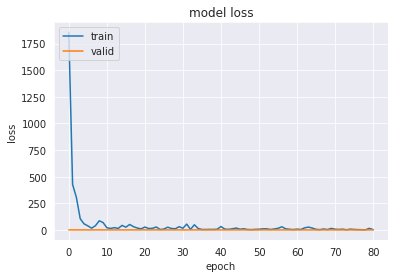

In [20]:
(history_list, 
scores_list, 

function_values_complete_list, 
function_values_valid_list, 
function_values_test_list, 

inet_preds_list, 
inet_preds_valid_list, 
inet_preds_test_list, 

distrib_dict_list,
model_list) = calculate_interpretation_net_results(lambda_net_train_dataset_list, 
                                                   lambda_net_valid_dataset_list, 
                                                   lambda_net_test_dataset_list)

## Evaluate Interpretation Net

In [21]:
if nas:
    for trial in history_list[-1]: 
        print(trial.summary())

In [22]:
if len(model_list) >= 1:
    print(model_list[-1].summary())
    print(model_list[-1].get_config())

In [23]:
scores_list[-1]

,MAE,RMSE,MAPE,Accuracy,Accuracy Multilabel,MAE FV,RMSE FV,MAPE FV,R2 FV,RAAE FV,RMAE FV,MEAN STD FV DIFF,MEAN FV1,MEAN FV2,STD FV1,STD FV2
inetPoly_VS_targetPoly_valid,0.237,0.331,6.833,0.227,0.000,0.033,0.041,0.743,0.343,0.314,0.591,0.037,-0.009,-0.005,0.549,0.554
inetPoly_VS_targetPoly_test,0.242,0.337,5.113,0.230,0.002,0.032,0.040,0.833,0.407,0.310,0.635,0.035,-0.039,-0.034,0.543,0.548
inetPoly_VS_predLambda_valid,NaN,NaN,NaN,NaN,NaN,0.015,0.018,0.580,0.950,0.120,0.212,0.016,-0.009,-0.004,0.549,0.550
inetPoly_VS_predLambda_test,NaN,NaN,NaN,NaN,NaN,0.016,0.019,0.600,0.955,0.120,0.190,0.017,-0.039,-0.034,0.543,0.545
inetPoly_VS_lstsqTarget_valid,0.825,1.103,35.883,0.109,0.000,0.354,0.407,2.376,-73.017,3.328,2.930,0.194,-0.009,-0.084,0.549,0.092
inetPoly_VS_lstsqTarget_test,0.818,1.093,21.077,0.108,0.000,0.347,0.399,2.397,-34.879,2.837,2.390,0.194,-0.039,-0.085,0.543,0.092
inetPoly_VS_lstsqLambda_valid,3.580,7.278,109.646,0.185,0.000,0.015,0.018,0.618,0.951,0.118,0.205,0.015,-0.009,-0.004,0.549,0.550
inetPoly_VS_lstsqLambda_test,3.793,7.528,61.695,0.182,0.000,0.015,0.019,0.596,0.956,0.118,0.185,0.016,-0.039,-0.034,0.543,0.545
lstsqLambda_VS_predLambda_valid,NaN,NaN,NaN,NaN,NaN,0.004,0.004,0.184,0.998,0.023,0.081,0.004,-0.004,-0.004,0.550,0.550
lstsqLambda_VS_predLambda_test,NaN,NaN,NaN,NaN,NaN,0.004,0.005,0.519,0.998,0.023,0.081,0.005,-0.034,-0.034,0.545,0.545


In [24]:
distrib_dict_list[-1]['MAE']

,L-0,L-1,L-2,L-3,L-4,L-5,L-6,L-7,L-8,L-9,L-10,L-11,L-12,L-13,L-14,L-15,L-16,L-17,L-18,L-19,L-20,L-21,L-22,L-23,L-24,L-25,L-26,L-27,L-28,L-29,L-30,L-31,L-32,L-33,L-34,L-35,L-36,L-37,L-38,L-39,L-40,L-41,L-42,L-43,L-44,L-45,L-46,L-47,L-48,L-49,L-50,L-51,L-52,L-53,L-54,L-55,L-56,L-57,L-58,L-59,L-60,L-61,L-62,L-63,L-64,L-65,L-66,L-67,L-68,L-69,L-70,L-71,L-72,L-73,L-74,L-75,L-76,L-77,L-78,L-79,L-80,L-81,L-82,L-83,L-84,L-85,L-86,L-87,L-88,L-89,L-90,L-91,L-92,L-93,L-94,L-95,L-96,L-97,L-98,L-99,L-100,L-101,L-102,L-103,L-104,L-105,L-106,L-107,L-108,L-109,L-110,L-111,L-112,L-113,L-114,L-115,L-116,L-117,L-118,L-119,L-120,L-121,L-122,L-123,L-124,L-125,L-126,L-127,L-128,L-129,L-130,L-131,L-132,L-133,L-134,L-135,L-136,L-137,L-138,L-139,L-140,L-141,L-142,L-143,L-144,L-145,L-146,L-147,L-148,L-149,L-150,L-151,L-152,L-153,L-154,L-155,L-156,L-157,L-158,L-159,L-160,L-161,L-162,L-163,L-164,L-165,L-166,L-167,L-168,L-169,L-170,L-171,L-172,L-173,L-174,L-175,L-176,L-177,L-178,L-179,L-180,L-181,L-182,L-183,L-184,L-185,L-186,L-187,L-188,L-189,L-190,L-191,L-192,L-193,L-194,L-195,L-196,L-197,L-198,L-199,L-200,L-201,L-202,L-203,L-204,L-205,L-206,L-207,L-208,L-209,L-210,L-211,L-212,L-213,L-214,L-215,L-216,L-217,L-218,L-219,L-220,L-221,L-222,L-223,L-224,L-225,L-226,L-227,L-228,L-229,L-230,L-231,L-232,L-233,L-234,L-235,L-236,L-237,L-238,L-239,L-240,L-241,L-242,L-243,L-244,L-245,L-246,L-247,L-248,L-249,...,L-750,L-751,L-752,L-753,L-754,L-755,L-756,L-757,L-758,L-759,L-760,L-761,L-762,L-763,L-764,L-765,L-766,L-767,L-768,L-769,L-770,L-771,L-772,L-773,L-774,L-775,L-776,L-777,L-778,L-779,L-780,L-781,L-782,L-783,L-784,L-785,L-786,L-787,L-788,L-789,L-790,L-791,L-792,L-793,L-794,L-795,L-796,L-797,L-798,L-799,L-800,L-801,L-802,L-803,L-804,L-805,L-806,L-807,L-808,L-809,L-810,L-811,L-812,L-813,L-814,L-815,L-816,L-817,L-818,L-819,L-820,L-821,L-822,L-823,L-824,L-825,L-826,L-827,L-828,L-829,L-830,L-831,L-832,L-833,L-834,L-835,L-836,L-837,L-838,L-839,L-840,L-841,L-842,L-843,L-844,L-845,L-846,L-847,L-848,L-849,L-850,L-851,L-852,L-853,L-854,L-855,L-856,L-857,L-858,L-859,L-860,L-861,L-862,L-863,L-864,L-865,L-866,L-867,L-868,L-869,L-870,L-871,L-872,L-873,L-874,L-875,L-876,L-877,L-878,L-879,L-880,L-881,L-882,L-883,L-884,L-885,L-886,L-887,L-888,L-889,L-890,L-891,L-892,L-893,L-894,L-895,L-896,L-897,L-898,L-899,L-900,L-901,L-902,L-903,L-904,L-905,L-906,L-907,L-908,L-909,L-910,L-911,L-912,L-913,L-914,L-915,L-916,L-917,L-918,L-919,L-920,L-921,L-922,L-923,L-924,L-925,L-926,L-927,L-928,L-929,L-930,L-931,L-932,L-933,L-934,L-935,L-936,L-937,L-938,L-939,L-940,L-941,L-942,L-943,L-944,L-945,L-946,L-947,L-948,L-949,L-950,L-951,L-952,L-953,L-954,L-955,L-956,L-957,L-958,L-959,L-960,L-961,L-962,L-963,L-964,L-965,L-966,L-967,L-968,L-969,L-970,L-971,L-972,L-973,L-974,L-975,L-976,L-977,L-978,L-979,L-980,L-981,L-982,L-983,L-984,L-985,L-986,L-987,L-988,L-989,L-990,L-991,L-992,L-993,L-994,L-995,L-996,L-997,L-998,L-999
inetPoly_VS_targetPoly_valid,0.048,0.013,0.012,0.028,0.037,0.013,0.026,0.025,0.035,0.014,0.079,0.021,0.030,0.031,0.065,0.146,0.022,0.027,0.013,0.031,0.024,0.019,0.020,0.023,0.035,0.029,0.008,0.037,0.063,0.024,0.023,0.012,0.022,0.020,0.061,0.046,0.030,0.032,0.033,0.029,0.065,0.035,0.046,0.028,0.026,0.024,0.019,0.044,0.029,0.024,0.102,0.019,0.023,0.013,0.010,0.022,0.030,0.028,0.036,0.032,0.109,0.034,0.035,0.032,0.018,0.037,0.012,0.037,0.030,0.025,0.033,0.031,0.032,0.046,0.005,0.081,0.016,0.024,0.031,0.011,0.004,0.022,0.011,0.022,0.035,0.012,0.030,0.034,0.062,0.049,0.014,0.044,0.100,0.025,0.036,0.021,0.019,0.039,0.024,0.043,0.037,0.023,0.021,0.044,0.025,0.038,0.021,0.009,0.019,0.019,0.027,0.012,0.028,0.026,0.039,0.017,0.063,0.011,0.055,0.014,0.025,0.017,0.019,0.014,0.131,0.034,0.029,0.016,0.011,0.028,0.026,0.032,0.020,0.114,0.009,0.015,0.025,0.034,0.041,0.021,0.021,0.023,0.014,0.050,0.021,0.020,0.030,0.012,0.051,0.020,0.036,0.067,0.042,0.022,0.030,0.059,0.130,0.023,0.028,0.028,0.021,0.033,0.013,0.025,0.029,0.017,0.032,0.024,0.048,0.030,0.034,0.022,0.025,0.036,0.015,0.146,0.027,0.029,0.024,0.

In [25]:
distrib_dict_list[-1]['R2']

,L-0,L-1,L-2,L-3,L-4,L-5,L-6,L-7,L-8,L-9,L-10,L-11,L-12,L-13,L-14,L-15,L-16,L-17,L-18,L-19,L-20,L-21,L-22,L-23,L-24,L-25,L-26,L-27,L-28,L-29,L-30,L-31,L-32,L-33,L-34,L-35,L-36,L-37,L-38,L-39,L-40,L-41,L-42,L-43,L-44,L-45,L-46,L-47,L-48,L-49,L-50,L-51,L-52,L-53,L-54,L-55,L-56,L-57,L-58,L-59,L-60,L-61,L-62,L-63,L-64,L-65,L-66,L-67,L-68,L-69,L-70,L-71,L-72,L-73,L-74,L-75,L-76,L-77,L-78,L-79,L-80,L-81,L-82,L-83,L-84,L-85,L-86,L-87,L-88,L-89,L-90,L-91,L-92,L-93,L-94,L-95,L-96,L-97,L-98,L-99,L-100,L-101,L-102,L-103,L-104,L-105,L-106,L-107,L-108,L-109,L-110,L-111,L-112,L-113,L-114,L-115,L-116,L-117,L-118,L-119,L-120,L-121,L-122,L-123,L-124,L-125,L-126,L-127,L-128,L-129,L-130,L-131,L-132,L-133,L-134,L-135,L-136,L-137,L-138,L-139,L-140,L-141,L-142,L-143,L-144,L-145,L-146,L-147,L-148,L-149,L-150,L-151,L-152,L-153,L-154,L-155,L-156,L-157,L-158,L-159,L-160,L-161,L-162,L-163,L-164,L-165,L-166,L-167,L-168,L-169,L-170,L-171,L-172,L-173,L-174,L-175,L-176,L-177,L-178,L-179,L-180,L-181,L-182,L-183,L-184,L-185,L-186,L-187,L-188,L-189,L-190,L-191,L-192,L-193,L-194,L-195,L-196,L-197,L-198,L-199,L-200,L-201,L-202,L-203,L-204,L-205,L-206,L-207,L-208,L-209,L-210,L-211,L-212,L-213,L-214,L-215,L-216,L-217,L-218,L-219,L-220,L-221,L-222,L-223,L-224,L-225,L-226,L-227,L-228,L-229,L-230,L-231,L-232,L-233,L-234,L-235,L-236,L-237,L-238,L-239,L-240,L-241,L-242,L-243,L-244,L-245,L-246,L-247,L-248,L-249,...,L-750,L-751,L-752,L-753,L-754,L-755,L-756,L-757,L-758,L-759,L-760,L-761,L-762,L-763,L-764,L-765,L-766,L-767,L-768,L-769,L-770,L-771,L-772,L-773,L-774,L-775,L-776,L-777,L-778,L-779,L-780,L-781,L-782,L-783,L-784,L-785,L-786,L-787,L-788,L-789,L-790,L-791,L-792,L-793,L-794,L-795,L-796,L-797,L-798,L-799,L-800,L-801,L-802,L-803,L-804,L-805,L-806,L-807,L-808,L-809,L-810,L-811,L-812,L-813,L-814,L-815,L-816,L-817,L-818,L-819,L-820,L-821,L-822,L-823,L-824,L-825,L-826,L-827,L-828,L-829,L-830,L-831,L-832,L-833,L-834,L-835,L-836,L-837,L-838,L-839,L-840,L-841,L-842,L-843,L-844,L-845,L-846,L-847,L-848,L-849,L-850,L-851,L-852,L-853,L-854,L-855,L-856,L-857,L-858,L-859,L-860,L-861,L-862,L-863,L-864,L-865,L-866,L-867,L-868,L-869,L-870,L-871,L-872,L-873,L-874,L-875,L-876,L-877,L-878,L-879,L-880,L-881,L-882,L-883,L-884,L-885,L-886,L-887,L-888,L-889,L-890,L-891,L-892,L-893,L-894,L-895,L-896,L-897,L-898,L-899,L-900,L-901,L-902,L-903,L-904,L-905,L-906,L-907,L-908,L-909,L-910,L-911,L-912,L-913,L-914,L-915,L-916,L-917,L-918,L-919,L-920,L-921,L-922,L-923,L-924,L-925,L-926,L-927,L-928,L-929,L-930,L-931,L-932,L-933,L-934,L-935,L-936,L-937,L-938,L-939,L-940,L-941,L-942,L-943,L-944,L-945,L-946,L-947,L-948,L-949,L-950,L-951,L-952,L-953,L-954,L-955,L-956,L-957,L-958,L-959,L-960,L-961,L-962,L-963,L-964,L-965,L-966,L-967,L-968,L-969,L-970,L-971,L-972,L-973,L-974,L-975,L-976,L-977,L-978,L-979,L-980,L-981,L-982,L-983,L-984,L-985,L-986,L-987,L-988,L-989,L-990,L-991,L-992,L-993,L-994,L-995,L-996,L-997,L-998,L-999
inetPoly_VS_targetPoly_valid,0.954,0.999,0.992,0.873,0.833,0.993,0.987,0.986,0.882,0.989,0.647,0.995,0.828,0.927,0.856,0.677,0.970,0.973,0.961,0.454,0.983,0.994,0.971,0.971,0.983,0.985,0.998,0.872,0.975,0.991,0.983,0.984,0.984,0.990,0.826,0.971,0.779,0.983,0.902,0.979,0.625,0.986,0.792,0.854,0.984,0.869,0.828,0.988,0.988,0.992,0.556,0.974,0.935,0.852,0.999,0.962,0.886,0.986,0.985,-1.869,0.698,0.950,0.948,0.870,0.933,0.981,0.996,0.952,0.732,0.985,0.716,0.747,0.718,0.957,0.248,0.841,0.971,0.992,-0.188,0.997,1.000,0.986,0.756,0.985,0.985,0.998,0.891,-1.934,0.721,0.715,0.829,0.889,0.848,0.931,0.985,0.795,0.996,0.992,0.980,0.981,0.995,0.984,0.983,0.314,0.811,0.984,0.702,0.997,0.979,0.981,0.852,0.963,0.742,0.994,0.983,0.853,0.651,0.997,-1.177,0.883,0.832,0.975,-1.799,0.949,0.731,0.979,0.992,0.993,0.933,0.982,0.981,0.996,0.968,0.719,0.990,0.997,0.993,0.748,0.844,0.973,0.962,0.917,0.994,-0.535,0.987,0.985,0.903,0.994,0.855,0.997,-0.223,0.844,0.920,0.846,0.972,0.383,0.591,0.854,0.926,0.805,0.994,0.912,0.911,0.990,0.864,0.975,0.970,0.990,0.955,0.966,0.988,-1.026,0.951,0.818,0.995,0.763,0.974,0.994,

In [26]:
index_min = int(np.argmin(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
polynomial_inet = inet_preds_test_list[-1][index_min]

print(distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'][index_min])

print_polynomial_from_coefficients(polynomial_inet)

-1.8782880229537082


<IPython.core.display.Math object>

In [27]:
index_min = int(np.argmin(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial

print(distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'][index_min])

polynomial_lambda = lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list[index_min]
print_polynomial_from_coefficients(polynomial_lambda)

-1.681159827457238


<IPython.core.display.Math object>

In [28]:
index_min = int(np.argmin(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial
polynomial_target = lambda_net_test_dataset.target_polynomial_list[index_min]
print_polynomial_from_coefficients(polynomial_target)

<IPython.core.display.Math object>

In [29]:
index_max = int(np.argmax(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
polynomial_inet = inet_preds_test_list[-1][index_max]

print(distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'][index_max])

print_polynomial_from_coefficients(polynomial_inet)

0.927840990462268


<IPython.core.display.Math object>

In [30]:
index_max = int(np.argmax(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial

print(distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'][index_max])

polynomial_lambda = lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list[index_max]
print_polynomial_from_coefficients(polynomial_lambda)

0.9551122428303366


<IPython.core.display.Math object>

In [31]:
index_max = int(np.argmax(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial
polynomial_target = lambda_net_test_dataset.target_polynomial_list[index_max]
print_polynomial_from_coefficients(polynomial_target)

<IPython.core.display.Math object>

In [32]:
r2_values_inet = distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test']
print('Mean: ' + str(np.mean(r2_values_inet)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_inet = r2_values_inet[r2_values_inet>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_inet)) + ' (' + str(r2_values_positive_inet.shape[0]) + ' Samples)')



Mean: 0.4068451285808552 (1000 Samples)
Mean (only positive): 0.8942902249539267 (931 Samples)


In [33]:
r2_values_lstsq_lambda = distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test']
print('Mean: ' + str(np.mean(r2_values_lstsq_lambda)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_lstsq_lambda = r2_values_lstsq_lambda[r2_values_lstsq_lambda>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_lstsq_lambda)) + ' (' + str(r2_values_positive_lstsq_lambda.shape[0]) + ' Samples)')



Mean: 0.2079008971103874 (1000 Samples)
Mean (only positive): 0.8896345367288271 (938 Samples)


<AxesSubplot:xlabel='inetPoly_VS_targetPoly_test', ylabel='Count'>

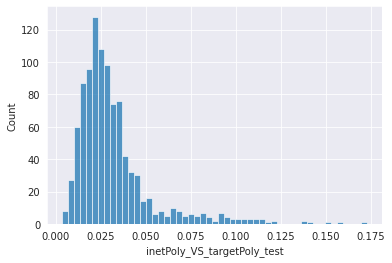

In [34]:
sns.histplot(distrib_dict_list[-1]['MAE'].loc['inetPoly_VS_targetPoly_test'])


<AxesSubplot:xlabel='lstsqLambda_VS_targetPoly_test', ylabel='Count'>

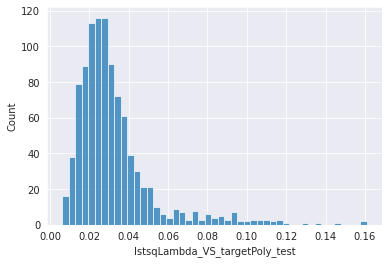

In [35]:
sns.histplot(distrib_dict_list[-1]['MAE'].loc['lstsqLambda_VS_targetPoly_test'])


[(-30.0, 1.0)]

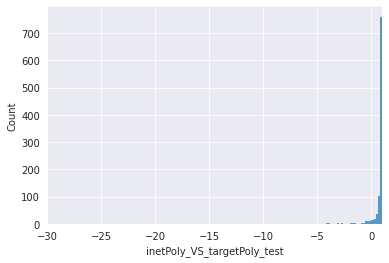

In [36]:
p = sns.histplot(distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'], binwidth=0.2)
p.set(xlim=(-30, 1))

[(0.0, 1.0)]

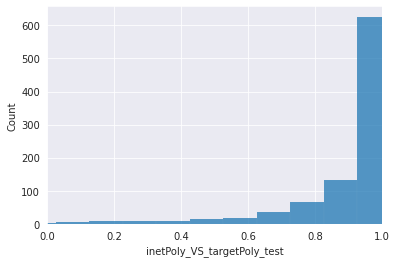

In [37]:
p = sns.histplot(distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'], binwidth=0.1)
p.set(xlim=(0, 1))

[(-10.0, 1.0)]

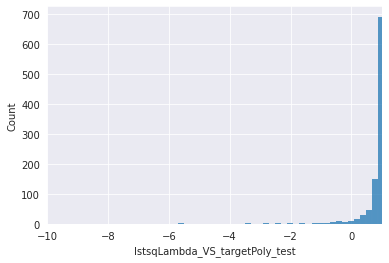

In [38]:
p = sns.histplot(distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'], binwidth=0.2)
p.set(xlim=(-10, 1))

[(0.0, 1.0)]

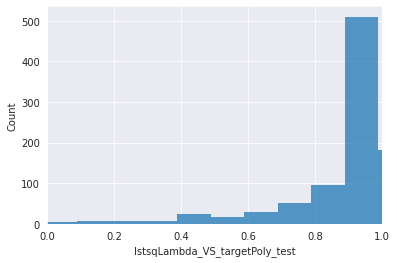

In [39]:
p = sns.histplot(distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'], binwidth=0.1)
p.set(xlim=(0, 1))

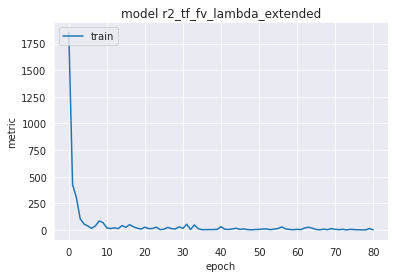

In [40]:
if not nas:
    history = history_list[-1]

    plt.plot(history[list(history.keys())[1]])
    if consider_labels_training or evaluate_with_real_function:
        plt.plot(history[list(history.keys())[len(history.keys())//2+1]]) 
    plt.title('model ' + list(history.keys())[1])
    plt.ylabel('metric')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/metric_' + path_identifier_interpretation_net_data + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')


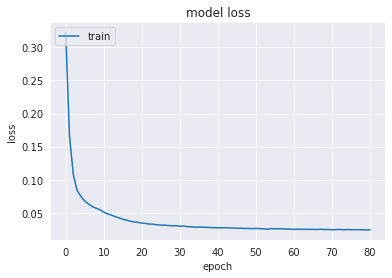

In [41]:
if not nas:
    history = history_list[-1]

    plt.plot(history['loss'])
    if consider_labels_training or evaluate_with_real_function:
        plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/loss_' + path_identifier_interpretation_net_data + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')    


### Multi Epoch/Sampes Analysis

### Generate Comparison Plots

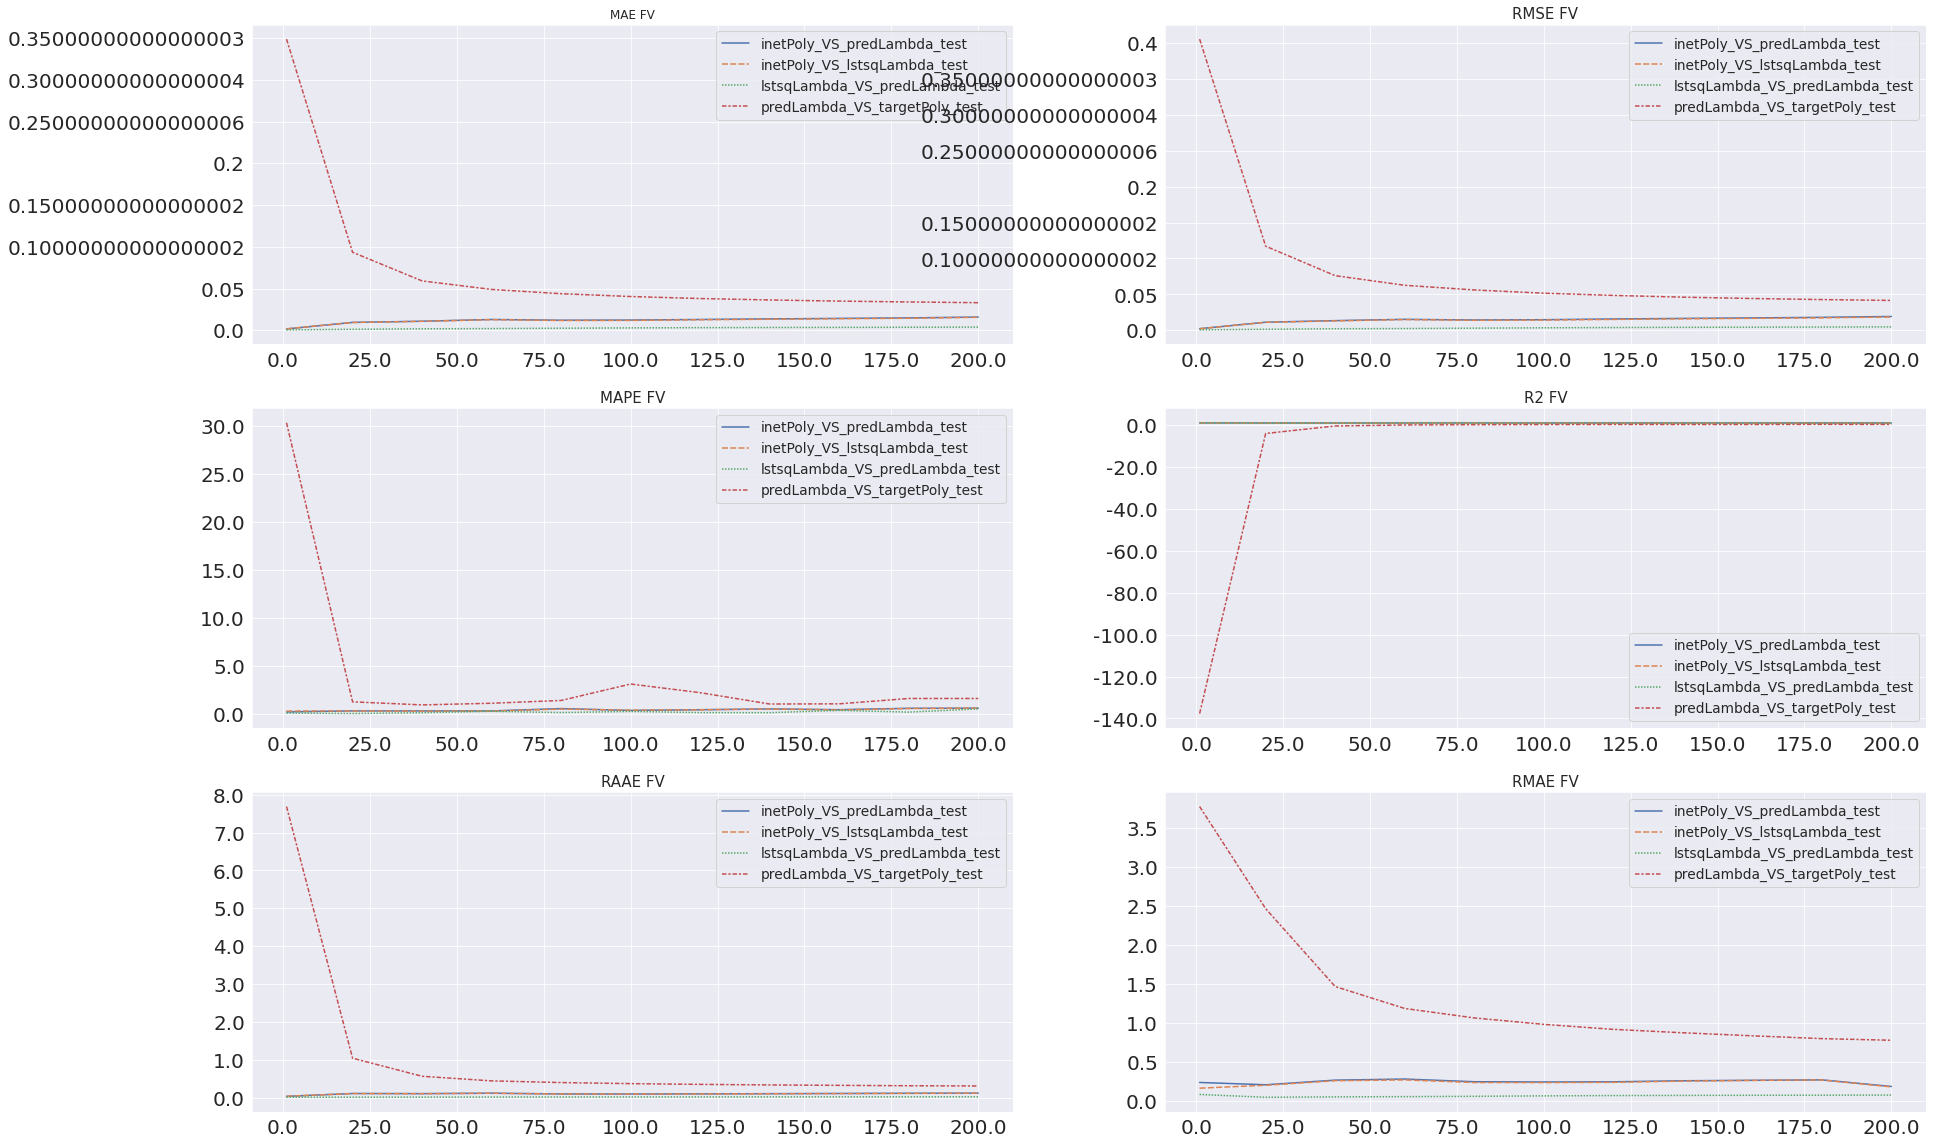

In [42]:
if len(scores_list) > 1:
    plot_metric_list = ['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV']

    generate_inet_comparison_plot(scores_list, plot_metric_list)

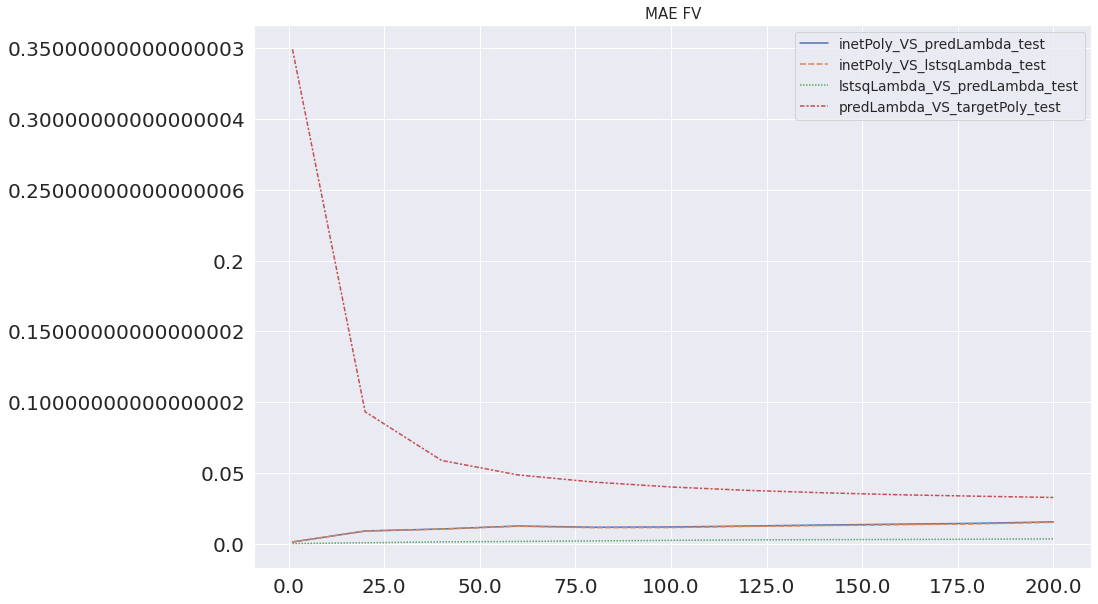

In [43]:
if len(scores_list) > 1:
    plot_metric_list = ['MAE FV']

    generate_inet_comparison_plot(scores_list, plot_metric_list)

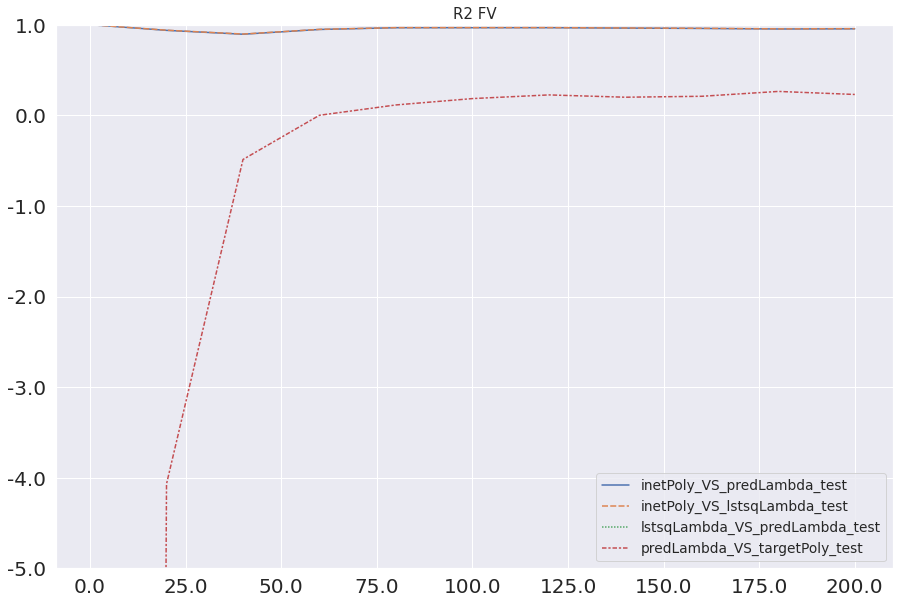

In [44]:
if len(scores_list) > 1:
    plot_metric_list = ['R2 FV']

    generate_inet_comparison_plot(scores_list, plot_metric_list, ylim=(-5, 1))

#### Generate and Analyze Predictions for Random Function

In [45]:
len(inet_preds_test_list)

11

In [46]:
len(lambda_net_test_dataset.target_polynomial_list)

1000

In [47]:
index = 3

polynomial_target = lambda_net_test_dataset.target_polynomial_list[index]
polynomial_lstsq_target = lambda_net_test_dataset.lstsq_target_polynomial_list[index]
polynomial_lstsq_lambda = lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list[index]
polynomial_inet = inet_preds_test_list[-1][index]

print_polynomial_from_coefficients(polynomial_target)
print_polynomial_from_coefficients(polynomial_lstsq_target)
print_polynomial_from_coefficients(polynomial_lstsq_lambda)
print_polynomial_from_coefficients(polynomial_inet)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

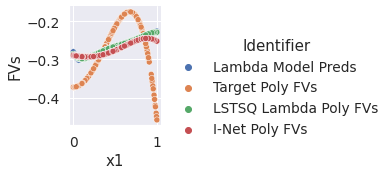

In [48]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      rand_index=index, 
                                                      plot_type=1)

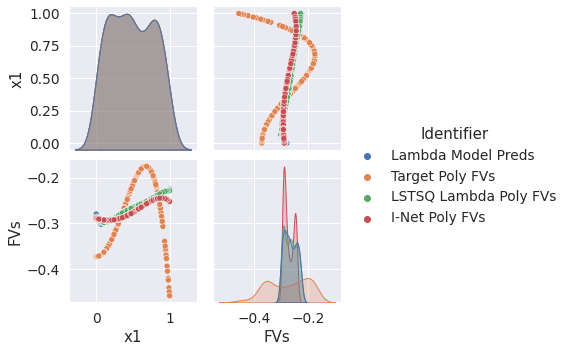

In [49]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      rand_index=index, 
                                                      plot_type=2)

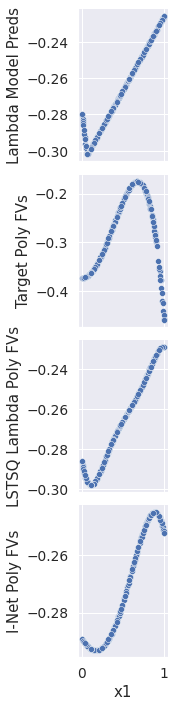

In [50]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      rand_index=index, 
                                                      plot_type=3)

# BENCHMARK (RANDOM GUESS) EVALUATION

In [51]:
list_of_random_polynomials = np.random.uniform(low=-10, high=10, size=(len(lambda_net_test_dataset_list[-1]), sparsity))

In [52]:
true_fv_test = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].test_data_list)
random_fv_test = parallel_fv_calculation_from_polynomial(list_of_random_polynomials, lambda_net_test_dataset_list[-1].test_data_list)

In [53]:
print('Random Guess Error Coefficients: ' + str(np.round(mean_absolute_error(lambda_net_test_dataset_list[-1].target_polynomial_list, list_of_random_polynomials), 4)))

Random Guess Error Coefficients: 5.0263


In [54]:
print('Random Guess Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, random_fv_test), 4)))

Random Guess Error FVs: 6.3416


# BENCHMARK (EDUCATED GUESS/MEAN PREDICTION) EVALUATION

In [55]:
true_fv_train = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].test_data_list)

mean_fv = np.mean(true_fv_train)
mean_fv_pred_test = [mean_fv for _ in range(true_fv_test.shape[0])]

In [56]:
print('Educated Guess/Mean Prediction Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, mean_fv_pred_test), 4)))

Educated Guess/Mean Prediction Error FVs: 0.3998


In [57]:
%%script false --no-raise-error

base_model = generate_base_model()
random_evaluation_dataset = np.random.uniform(low=x_min, high=x_max, size=(random_evaluation_dataset_size, n))
#random_evaluation_dataset = lambda_train_input_train_split[0]#lambda_train_input[0] #JUST [0] HERE BECAUSE EVALUATION ALWAYS ON THE SAME DATASET FOR ALL!!
list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)


loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

#X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))


seed_in_inet_training = False

loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))

seed_in_inet_training = True



In [58]:
if use_gpu:
    from numba import cuda 
    device = cuda.get_current_device()
    device.reset()